<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/2_3_RNN_samplecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


시계열 예측을 위한 RNN/LSTM 구현 코드

목적: 복합 신호 데이터를 학습하여 미래값을 예측하는 모델 구현
---
---
# 라이브러리 임포트

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# 재현 가능한 결과를 위한 난수 시드 고정
torch.manual_seed(0) # pytorch 난수 시드
np.random.seed(0) # numpy 난수 시드

In [ ]:
# @title  #하이퍼파라미터-1. 초기 설정 및 하이퍼파라미터 정의
SEQ_LEN = 40            # 입력 시퀀스의 (슬라이딩 창)길이 :과거 40개 데이터로 1개 미래값 예측
HIDDEN_SIZE = 64        # RNN/LSTM의 은닉 상태 차원 크기
NUM_LAYERS = 1          # RNN/LSTM 레이어 개수 (깊이)-RNN 은닉상태의 레이어 수
BATCH_SIZE = 64         # 배치 크기 (한 번에 처리할 데이터 개수)
NUM_EPOCHS = 120        # 전체 훈련 에포크 수
LR = 1e-3               # 학습률 (0.001)-1*10^(-3) =0.001

In [ ]:
# ============================================================================
# 2. 복합 시계열 데이터 생성
# ============================================================================

# 시간 축 생성: 0부터 200까지 2000개의 균등한 시간 포인트
t = np.linspace(0,200, 2000, dtype=np.float32) # 0~200까지 2000개
print(t.shape)# (2000,) 형태 확인
print(t[0])     # 첫 번째 값: 0.0
print(t[-2])    # 뒤에서 두 번째 값: 199.89995
print(t[-1])    # 마지막 값: 200.0

# 복합 신호 생성 (여러 주파수 성분을 합성한 복잡한 신호)-# 사인파 코사인의 주파수를 합성
signal = np.sin(2*np.pi*1.0*t)        # 기본파: 1Hz 사인파
signal += 0.6 * np.sin(2*np.pi*3.0*t) # 고조파1: 3Hz 사인파 (진폭 0.6)
signal += 0.6 * np.cos(2*np.pi*5.5*t) # 고조파2: 5.5Hz 코사인파 (진폭 0.6)

# 진폭 변조(AM) 추가: 저주파로 신호 강도 변화 시뮬레이션-# 저주파 진폭 변조
amp_mod = 1.0 + 0.4 * np.sin(2*np.pi*0.1 * t)  # 0.1Hz 변조 신호
signal *= amp_mod  # 진폭 변조 적용

# 선형 추세 추가: 시간에 따른 완만한 증가 추세-# 완만한 선형 추세선
signal += 0.002 * t

# 현실적인 노이즈 추가: 가우시안 노이즈로 실제 데이터와 유사하게 만들기-# 가우시안 노이즈
signal += 0.1 * np.random.randn(*t.shape)  # 표준편차 0.1인 정규분포 노이즈-# 표준분포를 따라가게된다?

# 2차원 배열로 변환: (2000,) → (2000, 1) (단일 특성을 가진 시계열)-# 단일 채널 형태로 (2000,1)
data = signal[:, np.newaxis]  # np.newaxis로 차원 확장 (PyTorch의 unsqueeze와 동일)-# 차원을 하나 늘렸다 ? unsqueeze 같은?

print(data.shape)    # (2000, 1) 형태 확인
print(signal.shape)  # (2000,) 형태 확인

(2000,)
0.0
199.89995
200.0
(2000, 1)
(2000,)


In [ ]:
# ============================================================================
# 3. 시퀀스 데이터 생성 함수
# ============================================================================
def make_sequences(arr, seq_len):
    xs, ys = [], []
    # 슬라이딩 윈도우로 시퀀스 생성
    for i in range(len(arr)-seq_len):
        x = arr[i:(i+seq_len)] # i부터 seq_len만큼의 입력 시퀀스- i 부터 시퀀스의 길이 만큼 데이터를 xs에 입력
        y = arr[i+seq_len]        # 다음 시점의 값 (예측 대상)- xs의 바로 다음 데이터rk ys에 입력
        xs.append(x)
        ys.append(y)

    return np.stack(xs), np.stack(ys)  # 리스트를 numpy 배열로 변환
# 시퀀스 데이터 생성
X, y = make_sequences(data, SEQ_LEN)
# X shape: (1960, 40, 1) - (샘플수, 시퀀스길이, 특성수)
# y shape: (1960, 1) - (샘플수, 예측값)

print(X.shape)
print(y.shape)
print(X[0])
print(y[0])

(1960, 40, 1)
(1960, 1)
[[ 0.6997845 ]
 [ 0.62917423]
 [ 1.2290232 ]
 [ 0.4162229 ]
 [ 1.2857513 ]
 [-0.07637029]
 [-1.688136  ]
 [-0.42191806]
 [-1.4155837 ]
 [-0.6980508 ]
 [-0.69892013]
 [ 2.2574666 ]
 [ 0.16160578]
 [ 1.2200075 ]
 [ 1.3202399 ]
 [ 0.061977  ]
 [-1.4222419 ]
 [-1.4321634 ]
 [-0.16400094]
 [-2.4277263 ]
 [ 0.91653043]
 [ 0.69018483]
 [ 1.3867174 ]
 [ 0.48996827]
 [ 1.9942812 ]
 [ 0.03386436]
 [-1.7825027 ]
 [-0.21705139]
 [-1.4818974 ]
 [-0.91785145]
 [-0.8754657 ]
 [ 2.2899997 ]
 [ 0.09204756]
 [ 1.131276  ]
 [ 1.1943893 ]
 [-0.09840348]
 [-1.1467398 ]
 [-1.271524  ]
 [-0.15985052]
 [-2.2148757 ]]
[0.804754]


In [ ]:
# @title #numpy ---> tensor ---> dataload
# NumPy 배열을 PyTorch 텐서로 변환
tensor_X = torch.from_numpy(X)
tensor_y = torch.from_numpy(y)

print(tensor_X.shape)
print(tensor_y.shape)
print(tensor_X[0])
print(tensor_y[0])

# 데이터셋과 데이터로더 생성 (배치 처리 및 셔플링)
dataset = TensorDataset(tensor_X, tensor_y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([1960, 40, 1])
torch.Size([1960, 1])
tensor([[ 0.6998],
        [ 0.6292],
        [ 1.2290],
        [ 0.4162],
        [ 1.2858],
        [-0.0764],
        [-1.6881],
        [-0.4219],
        [-1.4156],
        [-0.6981],
        [-0.6989],
        [ 2.2575],
        [ 0.1616],
        [ 1.2200],
        [ 1.3202],
        [ 0.0620],
        [-1.4222],
        [-1.4322],
        [-0.1640],
        [-2.4277],
        [ 0.9165],
        [ 0.6902],
        [ 1.3867],
        [ 0.4900],
        [ 1.9943],
        [ 0.0339],
        [-1.7825],
        [-0.2171],
        [-1.4819],
        [-0.9179],
        [-0.8755],
        [ 2.2900],
        [ 0.0920],
        [ 1.1313],
        [ 1.1944],
        [-0.0984],
        [-1.1467],
        [-1.2715],
        [-0.1599],
        [-2.2149]])
tensor([0.8048])


In [ ]:
# @title #RNN 모델 클래스 정의
class RNN(nn.Module):
    def __init__(self, input_size=1,
                 hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERs,
                 output_size=1):
        super(RNN, self).__init__()

        # RNN 레이어 정의
        self.rnn = nn.RNN(
            input_size=input_size,      # 입력 특성 수 (1)
            hidden_size=hidden_size,    # 은닉 상태 크기 (64)
            num_layers=num_layers,      # RNN 레이어 수 (1)
            batch_first=True           # 입력 형태를 (batch, seq, feature)로 설정-# (seq, batch, feat) -> (batch, seq, feat)이렇게 바꾸려고 넣었다
        )

        # 완전연결층 (RNN 출력을 최종 예측값으로 변환)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # RNN 순전파
        out, _ = self.rnn(x) # RNN 출력 --> (전체 output, h_n)
        # 마지막 시점의 출력만 사용
        out = out[:,-1,:]
        # 완전연결층 통과하여 최종 예측
        out = self.fc(out)
        return out


In [ ]:
# @title #RNN 모델 훈련 루
# GPU 사용 가능 시 GPU, 아니면 CPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = RNN().to(device) # 모델을 디바이스로 이동

print(model)
# model 안에 있는 레이어들을 다 보려면 어떤방법?????????????????????????

cpu
RNN(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# 손실함수와 옵티마이저 정의
loss_fn = nn.MSELoss()                           # 평균제곱오차
opt = optim.Adam(model.parameters(), lr=LR)      # Adam 옵티마이저

for epoch in range(NUM_EPOCHS):
    model.train() # 훈련 모드 (드롭아웃, 배치정규화 활성화)
    # train 모드가 있고, eval이벨루에이션 모드가 있다? 훈련할거니까 train 할게
    epoch_loss = 0

    for batch_X, batch_y in dataloader:
        # 데이터를 디바이스로 이동
        batch_X, batch_y = batch_X.to(device), batch_y.to(device) # 모델도 연결해줬으니까 들어가는 인풋도 연결해주기!

        # 1. 기울기 초기화 (이전 배치의 기울기 제거)
        opt.zero_grad()                 # 기울기 초기화
        # 2. 순전파 (모델 예측)# 모델에 집어넣고
        pred = model(batch_X)           # 모델의 예측(순전파)
        # 3. 손실 계산# 오차 구해라
        loss = loss_fn(pred, batch_y)   # loss 계산

        # 4. 역전파 (기울기 계산)# 로스 구한거 백워드해라
        loss.backward()                 # 역전파

        # 백워드하면 스텝밟아야지
        # 5. 파라미터 업데이트# 다음웨이트로 업데이트?
        opt.step()                      # parameter 업데이트

        epoch_loss += loss.item() * batch_X.size(0)

    # 평균 손실 계산 및 출력
    epoch_loss /= len(dataset)
    print(f"Epoch : {epoch} / loss: {epoch_loss}")



Epoch : 0 / loss: 0.6558771096930212
Epoch : 1 / loss: 0.3031770295026351
Epoch : 2 / loss: 0.09841804023908109
Epoch : 3 / loss: 0.062068843050878876
Epoch : 4 / loss: 0.06008324133498328
Epoch : 5 / loss: 0.05744148564277863
Epoch : 6 / loss: 0.05299537783982802
Epoch : 7 / loss: 0.05091598617787264
Epoch : 8 / loss: 0.05001214896233715
Epoch : 9 / loss: 0.049278505952382576
Epoch : 10 / loss: 0.049451291971668906
Epoch : 11 / loss: 0.04679346198634225
Epoch : 12 / loss: 0.04648724560226713
Epoch : 13 / loss: 0.04505741278431853
Epoch : 14 / loss: 0.04584831856951422
Epoch : 15 / loss: 0.04423145887498953
Epoch : 16 / loss: 0.04551742133133265
Epoch : 17 / loss: 0.042780355561752706
Epoch : 18 / loss: 0.042553447764746996
Epoch : 19 / loss: 0.04232634512745604
Epoch : 20 / loss: 0.0379085684917411
Epoch : 21 / loss: 0.0375409257199083
Epoch : 22 / loss: 0.037092390238326424
Epoch : 23 / loss: 0.03586689887606368
Epoch : 24 / loss: 0.035287920339983334
Epoch : 25 / loss: 0.03536067425

(1960, 1)
[0.75871205]


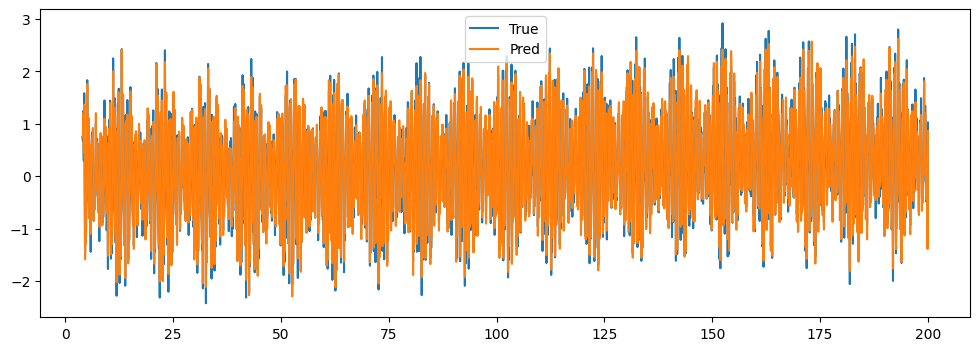

In [ ]:
# 평가 모드 (드롭아웃, 배치정규화 비활성화)-# 이벨르에이션모드는 파라미터가 얿데이트되지않는다?
model.eval() # 파라미터 따로 구하지 않고

# 기울기 계산 비활성화 (메모리 절약, 속도 향상)
with torch.no_grad():
    pred = model(tensor_X.to(device))    # 전체 데이터에 대한 예측
    preds = pred.cpu().numpy()           # GPU 텐서를 CPU NumPy로 변환
print(preds.shape)
print(preds[0])

# 결과 시각화
plt.figure(figsize=(12, 4))
plt.plot(t[SEQ_LEN:], data[SEQ_LEN:, 0], label='True')  # 실제값# 시퀀스 길이만큼 빼고 뒤에
plt.plot(t[SEQ_LEN:], preds.squeeze(), label='Pred')    # 예측값

plt.legend()
plt.show()

In [ ]:
# @title #LSTM모델
class LSTM(nn.Module):
    def __init__(self, input_size=1,
                 hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERs,
                 output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(  # RNN 대신 LSTM 사용
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x) # LSTM 출력 --> (전체 output, h_n)-(cell state는 무시)
        out = out[:,-1,:]
        out = self.fc(out)
        return out


In [ ]:
# @title ##model 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = LSTM().to(device)
print(model)
# model 안에 있는 레이어들을 다 보려면 어떤방법?????????????????????????

cpu
LSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# @title ##모델 학습
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
    model.train()# train 모드가 있고, eval이벨루에이션 모드가 있다? 훈련할거니까 train 할게
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device) # 모델도 연결해줬으니까 들어가는 인풋도 연결해주기!

        # 처음 들어갈때 기울기 초기화 해주기
        opt.zero_grad()                 # 기울기 초기화
        # 모델에 집어넣고
        pred = model(batch_X)           # 모델의 예측(순전파)
        # 오차 구해라
        loss = loss_fn(pred, batch_y)   # loss 계산

        # 로스 구한거 백워드해라
        loss.backward()                 # 역전파

        # 백워드하면 스텝밟아야지
        # 다음웨이트로 업데이트?
        opt.step()                      # parameter 업데이트

        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= len(dataset)
    print(f"Epoch : {epoch} / loss: {epoch_loss}")



Epoch : 0 / loss: 0.935189736132719
Epoch : 1 / loss: 0.7087763854435511
Epoch : 2 / loss: 0.48898250010548805
Epoch : 3 / loss: 0.4644914061439281
Epoch : 4 / loss: 0.4510321966239384
Epoch : 5 / loss: 0.44356747786609496
Epoch : 6 / loss: 0.4257210010168504
Epoch : 7 / loss: 0.4044924384477187
Epoch : 8 / loss: 0.40167245232329074
Epoch : 9 / loss: 0.3652907326513407
Epoch : 10 / loss: 0.33289881458087844
Epoch : 11 / loss: 0.28754633652920625
Epoch : 12 / loss: 0.25119423039105476
Epoch : 13 / loss: 0.21034308611130229
Epoch : 14 / loss: 0.17712560210909162
Epoch : 15 / loss: 0.14617953829619348
Epoch : 16 / loss: 0.13281859944061358
Epoch : 17 / loss: 0.12147245197271814
Epoch : 18 / loss: 0.10850838659977427
Epoch : 19 / loss: 0.09729138080562864
Epoch : 20 / loss: 0.09769420496055058
Epoch : 21 / loss: 0.08000581814926498
Epoch : 22 / loss: 0.08462199117152058
Epoch : 23 / loss: 0.071713986992836
Epoch : 24 / loss: 0.07816070750051615
Epoch : 25 / loss: 0.07192332163757208
Epoch 

(1960, 1)
[0.75014627]


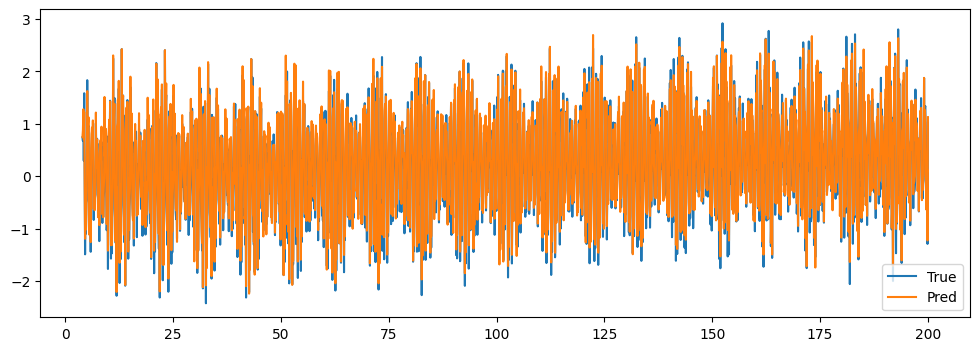

In [ ]:
# 이벨르에이션모드는 파라미터가 업데이트되지않는다?
model.eval() # 파라미터 따로 구하지 않고
# 기울기값 ?
with torch.no_grad(): # 기울기 구하지않음?
    pred = model(tensor_X.to(device))
    preds = pred.cpu().numpy()

print(preds.shape)
print(preds[0])

plt.figure(figsize=(12,4))
plt.plot(t[SEQ_LEN:], data[SEQ_LEN:,0], label='True') # 시퀀스 길이만큼 빼고 뒤에
plt.plot(t[SEQ_LEN:], preds.squeeze(), label='Pred') # 나온거??

plt.legend()
plt.show()